<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - SVM
    <br>
<font color=black size=4>
    Alireza Gargoori Motlagh, Alireza Heidari
    
<br><br>
<font size=4>
   **Name**: <br>
   **Student ID**: <br> <br>
In this homework, we are going to implement the algorithms from the second and third chapters of the course, so reading the notebooks of these chapters would be quite useful. Also, we are going to evaulate and compare our models by the metrics defined in chapter 3. Keep in mind to complete all of the following questions and write your own codes in the TODO parts.

## <font face="Times New Roman" size=4><div dir=ltr>
## Problem 3: Face Classification by SVM on Eigenfaces (150 points)
In the following problem, we are going to build a classifier to distinguish the faces of 40 people on a toy dataset. The dataset includes 400 pictures of 40 people faces, each by a 64*64 pixel picture. Use the following cell to download the dataset:

In [80]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

faces = datasets.fetch_olivetti_faces()
print(faces.data.shape)
print(faces.images[0].shape)

(400, 4096)
(64, 64)


<font face="Times New Roman" size=4><div dir=ltr>
### Visualization of the Faces (5 points)
Plot an image of each class in one figure using subplots. (Note that the design matrix X is availabe in <code>faces.data</code> and the target values available in <code>faces.target</code> .)

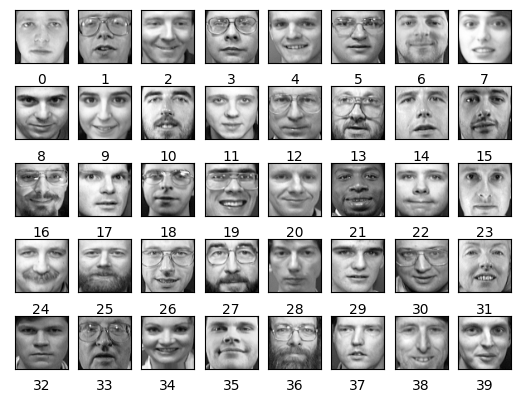

In [81]:
fig, ax = plt.subplots(5, 8)
checked_faces = []
for i , axi in enumerate(ax.flat):
    axi.imshow(faces.images[10 * i], cmap='binary_r')
    axi.set(xticks=[], yticks=[], xlabel=faces.target[10 * i])
plt.show()

<font face="Times New Roman" size=4><div dir=ltr>
### Train-Test Split (2 points)
Split the data into train and test sets and print the dimensions of each set. (70% for train and 30% for test)

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size= 0.3 , random_state=42)

<font face="Times New Roman" size=4><div dir=ltr>
### Dimensionality Reduction (18 points)
As you might have guessed, the number of featuers, i.e. pixels, is quite large and training a classifier might take a considerbale time. However, using a wise method to reduce the dimension of our data could decrease the cost of training the model. In the following cell use PCA (Principal Component Analysis) to reduce the dimension of the dataset. Choose an appropirate number of components in your PCA and explain your reason for your choice.

In [83]:

#zero-mean
X_train_mean = np.mean(X_train, axis=0)
X_test_mean = np.mean(X_test, axis=0)
X_train_zero_mean = X_train - X_train_mean
X_test_zero_mean = X_test - X_test_mean

#covariance matrix
cov_matrix = np.dot(X_train_zero_mean.T, X_train_zero_mean) / (X_train_zero_mean.shape[0]-1)
print(cov_matrix.shape)

#eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)


(4096, 4096)


<font face="Times New Roman" size=4><div dir=ltr>
Plot the scree plot of the proportion of the variance explained(PVE) vs principal components to determine the number of principal components for futher analysis.

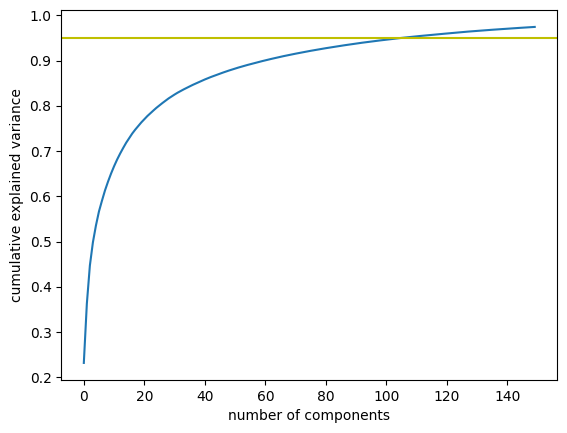

In [84]:
# show it for its fist 150 components
# plot the line for 95% of the variance explained on the same plot
plt.plot(np.cumsum(eigenvalues[:150]) / np.sum(eigenvalues))
plt.axhline(y=0.95, color='y')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


<b> the number of components should be chosen in a way that the 95 percent of data variance be kept. it can be proved that sum of chosen eigenvalues divided by sum of all eigenvalues is equal to data variance. so we can choose the number of components as the number of eigenvalues that their sum is equal to 95 percent of sum of all eigenvalues. </b>

In [85]:
# find appropriate number of components
number_of_components = 0
total_sum = sum(eigenvalues)
current_sum = 0
while current_sum  < 0.95 * total_sum:
    current_sum += eigenvalues[number_of_components]
    number_of_components += 1
print(number_of_components)


106


<b> keep best 106 components as the reducer matrix U </b>

In [86]:
U = eigenvectors[:, :number_of_components]

<font face="Times New Roman" size=4><div dir=ltr>
### Eigenfaces: Principal Components Visualization (25 points)
Plot the mean face using your PCA model with <code>pca.mean_</code> attribute followed by a reshape to original dimensions. What is this mean vector?

the mean vector is the average of all the images in the train set. it has the average value of each pixel in the train set.

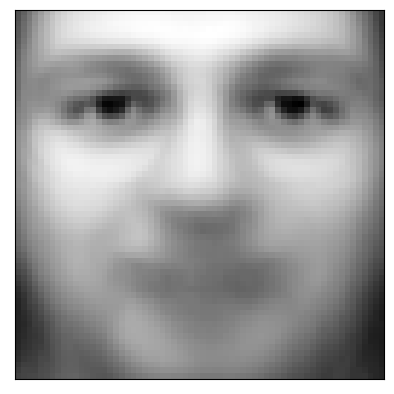

In [87]:
fig, ax = plt.subplots(1, 1)
ax.imshow(X_train_mean.reshape(64, 64), cmap='binary_r')
ax.set(xticks=[], yticks=[])
plt.show()

<font face="Times New Roman" size=4><div dir=ltr>
Eigenfaces is the name given to a set of eigenvectors when used in the computer vision problem of human face recognition. Plot the 30 first eigenfaces sorted by their rank from the most important to the lowest. Can you explain what these faces indicate?

the eigenfaces are the dimensions that images(people) seem to vary the most. so the first eigenvector is the most important dimension that images vary in.the second eigenvector is the second most important dimension that images vary in. and so on. for example in the first eigenface showed in the plot, its seems that one of features that images vary in is having beard or not.

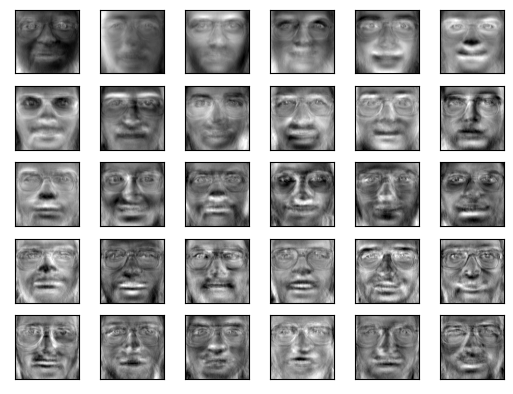

In [88]:
fig, ax = plt.subplots(5, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(U[:, i].reshape(64, 64), cmap='binary_r')
    axi.set(xticks=[], yticks=[])
plt.show()

<font face="Times New Roman" size=4><div dir=ltr>
Transform your train and test sets to the new feature space using your PCA module. 

In [89]:
X_train_pca = np.dot(X_train_zero_mean, U)
X_test_pca = np.dot(X_test_zero_mean, U)

<font face="Times New Roman" size=4><div dir=ltr>
### Training your SVM Classifier (50 points)
Train an SVM classifier on the transformed dataset in the new feature space. You should use Grid Search Cross Validation or other validation techniques to obtain the best hyperparameters for your classifier. 

In [90]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'degree': [2, 3, 4, 5],
              'gamma': [0.0001 , 0.001 , 0.01 , 0.1 ]}
grid_search_svm = GridSearchCV(svm.SVC(), param, cv=10)
grid_search_svm.fit(X_train_pca, y_train)
print(f"best parameters:{grid_search_svm.best_params_}")
print(f"best cross validation score: {grid_search_svm.best_score_}")


best parameters:{'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
best cross validation score: 0.9535714285714285


<font face="Times New Roman" size=4><div dir=ltr>
After training your model, we can check its prediction on test samples. Run the following cell to check your model predictions with the target values on test samples. Predictions with red label indicate false classification of your model.

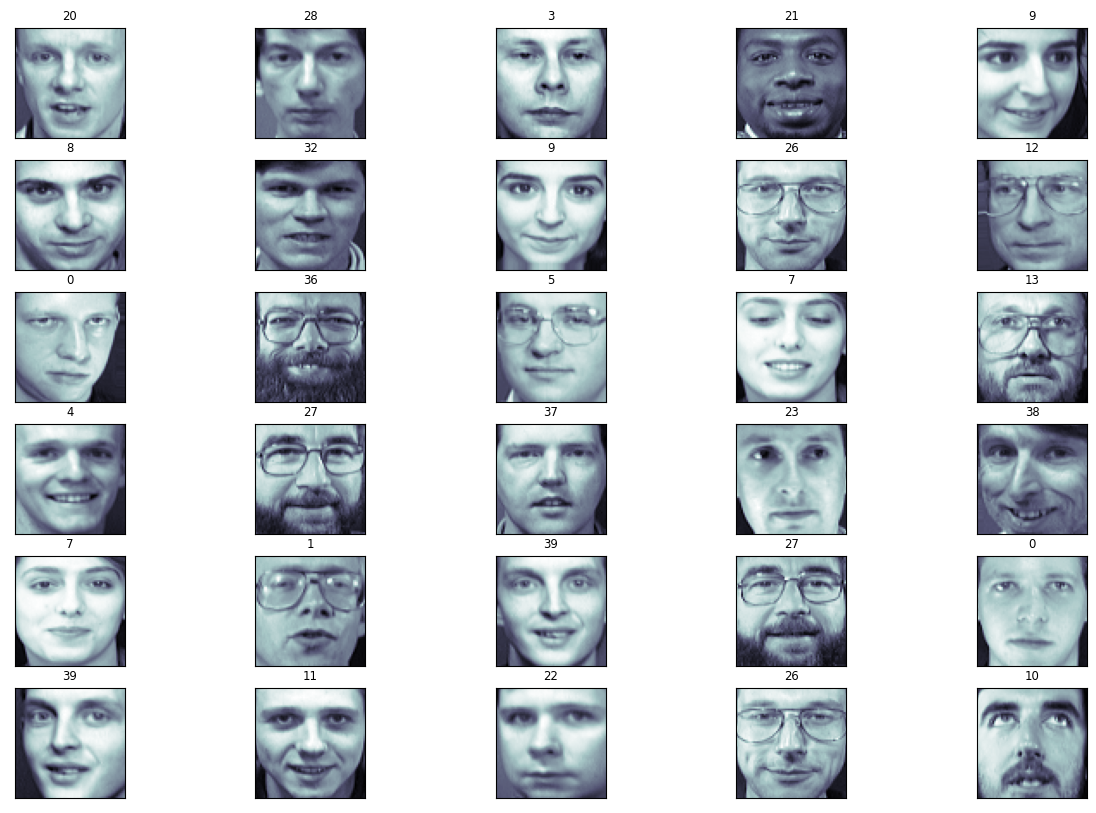

In [91]:
fig = plt.figure(figsize=(15, 10))
for i in range(30):
    ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = grid_search_svm.predict(X_test_pca[i, np.newaxis])[0] #X_test_new is the transformed X_test after PCA.
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

<font face="Times New Roman" size=4><div dir=ltr>
## Performance Measures
Let's evaluate your classifier to find out how good your model is.
    
    
### Precision Recall Tradeoff (20 points)
Plot the precision and recall versus the decision threshold figure and precision vs recall figure.

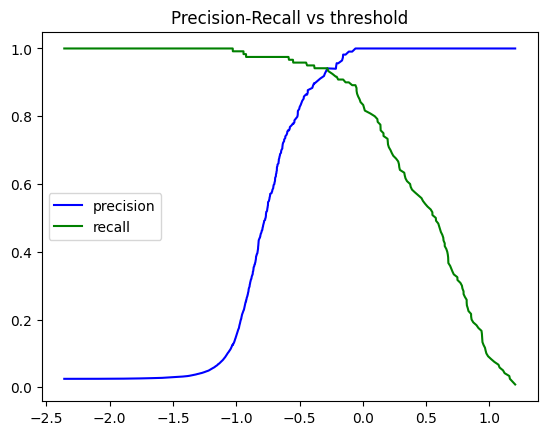

In [92]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score

# label_binarize
target_oneHot = label_binarize(faces.target, classes= range(40))

# split into training and test
X_train_oneHot, X_test_oneHot, y_train_oneHot, y_test_oneHot = train_test_split\
    (faces.data, target_oneHot, test_size= 0.3 , random_state=42)

# zero-mean
X_train_oneHot_mean = np.mean(X_train_oneHot, axis=0)
X_test_oneHot_mean = np.mean(X_test_oneHot, axis=0)
X_train_oneHot_zero_mean = X_train_oneHot - X_train_oneHot_mean
X_test_oneHot_zero_mean = X_test_oneHot - X_test_oneHot_mean

# pca
X_train_oneHot_pca = np.dot(X_train_oneHot_zero_mean, U)
X_test_oneHot_pca = np.dot(X_test_oneHot_zero_mean, U)

# use one_vs_rest classifier
ovr_svm = OneVsRestClassifier(grid_search_svm.best_estimator_)
ovr_svm.fit(X_train_oneHot_pca, y_train_oneHot)
y_score = ovr_svm.decision_function(X_test_oneHot_pca)

# Compute  precision-recall curve and micro average precision
precision, recall, threshold = precision_recall_curve(y_test_oneHot.ravel(),
    y_score.ravel())
average_precision = average_precision_score(y_test_oneHot, y_score,
                                                     average="micro")

# plot percision and recall vs threshold
fig, ax = plt.subplots(1, 1)
ax.plot(threshold, precision[:-1], 'b', label='precision')
ax.plot(threshold, recall[:-1], 'g', label='recall')
ax.legend()
plt.title('Precision-Recall vs threshold')
plt.show()

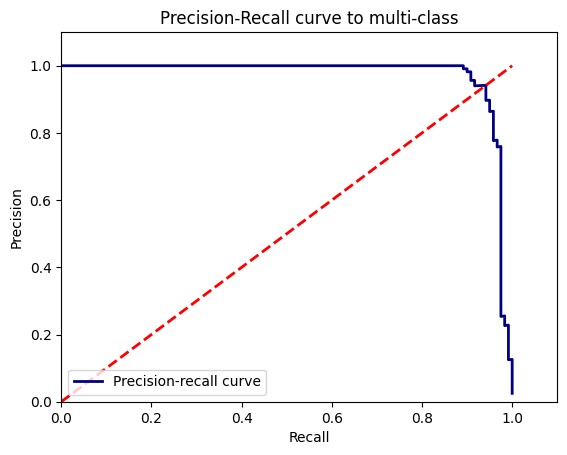

In [93]:
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall, precision, lw=2, color='navy',
         label='Precision-recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1.1])
plt.title('Precision-Recall curve to multi-class')
plt.legend(loc="lower left")

# plot the precision = recall line
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.show()

<font face="Times New Roman" size=4><div dir=ltr>
Then find the decision threshold, where the recall is equal to the precision. Write down it in the below cell:
    <br>
note: it should be apparent in the above figures.

In [94]:
# find the decision threshold where the precision = recall line
for i in range(len(precision)):
    if precision[i] == recall[i]:
        print(f"the decision threshold is {threshold[i]} and the precision=recall is {precision[i]}")

the decision threshold is -0.2797652825597179 and the precision=recall is 0.9416666666666667


decision_threshold = -0.2797652825597179

recall at the above threshold = 0.9416666666666667

<font face="Times New Roman" size=4><div dir=ltr>
### ROC/AUC (10 points)
Train a RandomForestClassifier with 30 estimators then plot a ROC curve, and calculate AUC for both randomForsetClassifier and your SVM classifier that you trained earlier, which one is the best by considering AUC indicator?


In [95]:
from sklearn.ensemble import RandomForestClassifier
#Train the random forest on the dataset
rf = RandomForestClassifier(n_estimators=30, random_state=42)
ovr_rf = OneVsRestClassifier(rf)
ovr_rf.fit(X_train_oneHot_pca, y_train_oneHot)
y_rf_score = ovr_rf.predict_proba(X_test_oneHot_pca)


auc of svm is 0.9969551282051282
auc of random forest is 0.8907282763532762


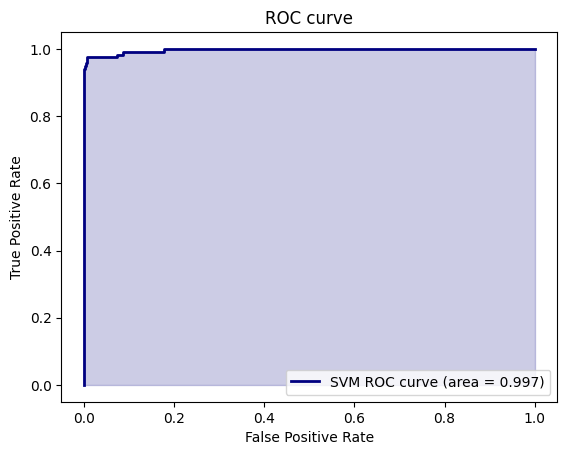

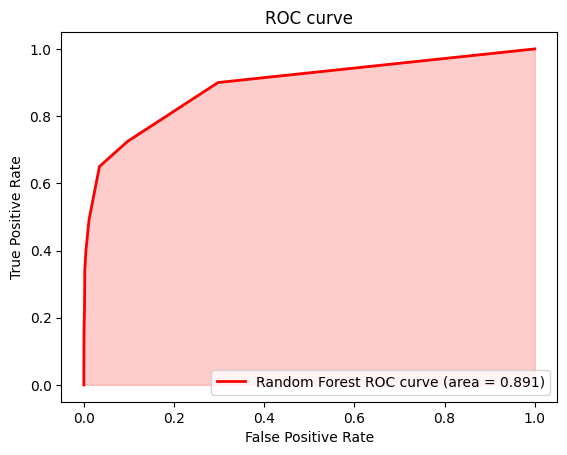

In [96]:
from sklearn.metrics import roc_curve, roc_auc_score

#calculate the false positive rate and true positive rate 
false_positive_rate_svm, true_positive_rate_svm, thresholds_svm = roc_curve(y_test_oneHot.ravel(), y_score.ravel())
false_positive_rate_rf, true_positive_rate_rf, thresholds_rf = roc_curve(y_test_oneHot.ravel(), y_rf_score.ravel())
auc_svm = roc_auc_score(y_test_oneHot, y_score, average="micro")
auc_rf = roc_auc_score(y_test_oneHot, y_rf_score, average="micro")

print(f"auc of svm is {auc_svm}")
print(f"auc of random forest is {auc_rf}")
#plot the ROC curve for the SVM

plt.clf()
plt.plot(false_positive_rate_svm, true_positive_rate_svm, lw=2, color='navy',
         label='SVM ROC curve (area = %0.3f)' % auc_svm)
plt.fill_between(false_positive_rate_svm, true_positive_rate_svm, color='navy', alpha=0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

#plot the ROC curve for the random forest
plt.clf()
plt.plot(false_positive_rate_rf, true_positive_rate_rf, lw=2, color='red',
         label='Random Forest ROC curve (area = %0.3f)' % auc_rf)
plt.fill_between(false_positive_rate_rf, true_positive_rate_rf, color='red', alpha=0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()




<b> the SVM classifier has a better AUC than the Random Forest classifier so it is better. </b>

<font face="Times New Roman" size=4><div dir=ltr>
### Classification Report (5 points)
Use the <code>classification_report</code> to describe the performance of your SVM model with different metrics. Explain your results and compare the predictions of model on different classes in few sentences.

In [100]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
print(classification_report(y_test_oneHot.argmax(axis=1), y_score.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      0.75      0.86         8
           8       1.00      1.00      1.00         2
           9       0.60      1.00      0.75         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       0.00      0.00      0.00         0
          17       1.00    

<br>each class has a precision, recall and f1-score. the precision is the number of true positives divided by the number of true positives and false positives.when the precision is high, the model is good at predicting the positive instances.it means that the model tries not to label a negative data , true wrongly </br>
<br>
the recall is the number of true positives divided by the number of true positives and false negatives. when the recall is high, the model can find all the positive instances. it means that model is so sensitive to the a positive instance and it cant miss any positive instance.for example in class 0 the recall is 0.60 which means that the model can find 60 percent of the positive instances of class 0 and as we know it has 5 positive instances so it can find 3 of them. </br>
</br>
<br>
the f1-score is the harmonic mean of precision and recall. when the f1-score is high, the model is good at both precision and recall.it means that the model is good at both predicting positive instances and finding all the positive instances.
</br>
<br>
the support is the number of true instances for each class.it helps us to know in any class precision is more important than recall or vice versa. for example if number of true instances are more than negative instances, we can say that recall is more important than precision.because when the number of negative instances are a few its obvious that number of false positives will be so low and the precision will be high.
</br>

<b> conclusion: </b>
<br>
in our model we can see that both precision and recall is high for almost all classes. so the model is good at both predicting positive instances and finding all the positive instances.
</br>


<font face="Times New Roman" size=4><div dir=ltr>
### Confusion Matrix (15 points)
Plot the confusion matrix of the classifier's predictions.
Let’s focus on the errors of the plot. Divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute number of errors, then plot the result.

In [111]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test_oneHot.argmax(axis=1), y_score.argmax(axis=1))
print(conf_mx)

[[3 0 0 ... 0 0 1]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 3]]


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


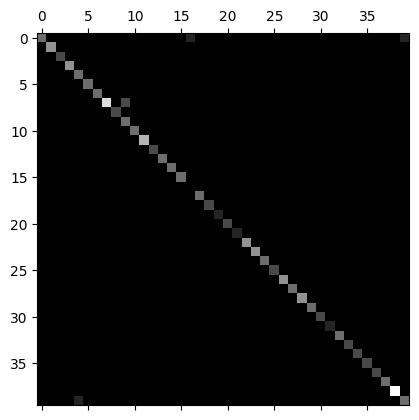

In [123]:
# TODO: after calculating confusion matrix, visualize it using below code

plt.matshow(conf_mx, cmap=plt.cm.gray)
print(conf_mx[:,16])
plt.show()

In [127]:
# calculate norm_conf_mx then print it
row_sums = conf_mx.sum(axis=0, keepdims=True)
norm_conf_mx = conf_mx / row_sums

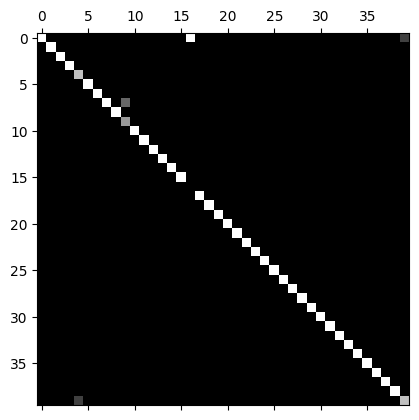

In [128]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()